# Anemia Types Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Model Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Model Eval Imports
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

# Sampling Imports
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Functions

In [2]:
def check_nulls(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Duplicates: {df.duplicated().sum()}")

def check_class_imbalances(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(17, 12))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 6))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.title("Target Class Breakdown")
  plt.show()

def plot_model_performance(df, y, axis):
  fig, ax = plt.subplots(figsize=(15, 8))
  df.plot.bar(x="Model",y=y, ax=ax)
  ax.set_xlabel("Model Performance")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance")
  plt.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def create_pipeline_object(model=None):
  
  steps = steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer())
  ]
  if model is not None:
    steps.append(
      ("Model", model)
    )
  return Pipeline(steps=steps)

def create_sampling_pipeline(sampling_model, model, kbest=None):
  
  steps = [
    ("sample", sampling_model),
    ("model", model)
  ]
  if kbest is not None:
    steps.insert(1, ("kbest", kbest))
  
  return imbPipeline(steps=steps)

def create_confusion_matrix(y_pred, y_test, model_name, data_type):
  
  plt.figure(figsize=(10, 6))
  cm = confusion_matrix(y_pred, y_test)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix -> Model:{model_name} -> {data_type}")
  plt.xlabel("True Labels")
  plt.ylabel("Predicted Labels")
  plt.xticks(rotation=45)
  plt.show()
  

def evaluate_model(X,y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  return scores

def tested_selected_models(model_names, models, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    pipeline = create_pipeline_object(model)
    scores = evaluate_model(X, y, pipeline)
    model_performance.append({
      "Model":model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def get_metrics(val_pred, y_val, test_pred, y_test):

  val_acc = accuracy_score(val_pred, y_val)
  test_acc = accuracy_score(test_pred, y_test)
    
  val_f1_score = f1_score(val_pred, y_val, average="micro")
  test_f1_score = f1_score(test_pred, y_test, average="micro")
    
  val_f2_score = fbeta_score(val_pred, y_val, average="micro", beta=0.5)
  test_f2_score = fbeta_score(test_pred, y_test, average="micro", beta=0.5)
  
  return [
    val_acc,
    test_acc,
    val_f1_score,
    test_f1_score,
    val_f2_score,
    test_f2_score
  ]

def create_train_test_splits(X, y):
  
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  
  return X_train, X_test, X_val, y_train, y_test, y_val

def test_predictions(model_names, models, X, y):
  
  X_train, X_test, X_val, y_train, y_test, y_val= create_train_test_splits(X, y)
  model_performance = []
  for i in range(len(models)):
    model_name, model = model_names[i], models[i]
    
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    test_pred =model.predict(X_test)
    
    val_acc, test_acc, val_f1_score, test_f1_score, val_f2_score, test_f2_score = get_metrics(val_pred, y_val, test_pred, y_test)
    create_confusion_matrix(test_pred, y_test, model_name, "Test Data")
    
    model_performance.append({
      "Model": model_name,
      "Test-F1-Score": test_f1_score,
      "Val-F1-Score": val_f1_score,
      "Test-F2-Score": test_f2_score,
      "Val-F2-Score": val_f2_score,
      "Test-Acc": test_acc,
      "Val-Acc": val_acc
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test-F1-Score", ascending=False).reset_index()
  plot_model_performance(
    model_performance_df,
    ["Test-F1-Score", "Val-F1-Score", "Test-F2-Score", "Val-F2-Score", "Test-Acc", "Val-Acc"], 
    "Metrics"
    )
  print(model_performance_df)

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "KNN": SMOTE(k_neighbors=5)
  }
  
  return [models[model_name] for model_name in model_names]

def test_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y):
  
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      scores = evaluate_model(X, y, pipeline)
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD"], "Mean")
  print(performance_df)

def test_sampling_model_predictions(sampling_model_names, sampling_models, 
                                    model_names, models, X, y,
                                    kbest=None
                                    ):
  
  X_train, X_test, X_val, y_train, y_test, y_val= create_train_test_splits(X, y)
  model_performance = []
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model) if not kbest else create_sampling_pipeline(sample_model, model, kbest)
      pipeline.fit(X_train, y_train)
    
      val_pred = pipeline.predict(X_val)
      test_pred =pipeline.predict(X_test)
      
      val_acc, test_acc, val_f1_score, test_f1_score, val_f2_score, test_f2_score = get_metrics(val_pred, y_val, test_pred, y_test)
      
      combined_model_name = sample_model_name + "-" + model_name
      create_confusion_matrix(test_pred, y_test, combined_model_name, "Test Data")
      
      model_performance.append({
      "Model": combined_model_name,
      "Test-F1-Score": test_f1_score,
      "Val-F1-Score": val_f1_score,
      "Test-F2-Score": test_f2_score,
      "Val-F2-Score": val_f2_score,
      "Test-Acc": test_acc,
      "Val-Acc": val_acc
    })
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test-F1-Score", ascending=False).reset_index()
  plot_model_performance(
    model_performance_df,
    ["Test-F1-Score", "Val-F1-Score", "Test-F2-Score", "Val-F2-Score", "Test-Acc", "Val-Acc"], 
    "Metrics"
    )
  print(model_performance_df)
  
def pca_analysis(X):
    
    features = range(1, X.shape[1]+1)
    model_performance = []
    
    for n_component in features:
      pca = PCA(n_components=n_component)
      X_pca = pca.fit_transform(X)
      
      explained_variance = np.sum(pca.explained_variance_ratio_)
      
      model_performance.append({
        "Model": "Col-Number" + "-" + str(n_component),
        "N Component": n_component,
        "Cumulative Explained VAR": explained_variance
      })

    df = pd.DataFrame(model_performance)
    plot_model_performance(df, ["Cumulative Explained VAR"], "CUM- Variance")
    print(df)

def test_kBest_columns(model_names,sampling_names, models, 
                       sampling_models, X, y, variance_window, kMetric
                       ):
  
  model_performance = []
  for k in variance_window:
    kbest = SelectKBest(score_func=kMetric, k=k)
    for idx in range(len(sampling_models)):
      model, model_name = models[idx], model_names[idx]
      sampling_model, sample_model_name = sampling_models[idx], sampling_names[idx]
      pipeline = create_sampling_pipeline(sampling_model, model, kbest)
      scores = evaluate_model(X, y, pipeline)
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
      "K":k
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD", "K"], "Mean")
  print(performance_df)


# EDA

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.00,43.200,50.100,4.30000,5.00000,2.77,7.3,24.2000,87.7,26.3,30.1,189.0,12.500000,0.17000,Normocytic hypochromic anemia
1,10.00,42.400,52.300,4.20000,5.30000,2.84,7.3,25.0000,88.2,25.7,20.2,180.0,12.500000,0.16000,Normocytic hypochromic anemia
2,7.20,30.700,60.700,2.20000,4.40000,3.97,9.0,30.5000,77.0,22.6,29.5,148.0,14.300000,0.14000,Iron deficiency anemia
3,6.00,30.200,63.500,1.80000,3.80000,4.22,3.8,32.8000,77.9,23.2,29.8,143.0,11.300000,0.12000,Iron deficiency anemia
4,4.20,39.100,53.700,1.60000,2.30000,3.93,0.4,316.0000,80.6,23.9,29.7,236.0,12.800000,0.22000,Normocytic hypochromic anemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,4.40,25.845,77.511,1.88076,5.14094,4.86,13.5,46.1526,80.7,27.7,34.4,180.0,14.312512,0.26028,Healthy
1277,5.60,25.845,77.511,1.88076,5.14094,4.85,15.0,46.1526,91.7,31.0,33.8,215.0,14.312512,0.26028,Healthy
1278,9.20,25.845,77.511,1.88076,5.14094,4.47,13.1,46.1526,88.7,29.3,33.0,329.0,14.312512,0.26028,Healthy
1279,6.48,25.845,77.511,1.88076,5.14094,4.75,13.2,46.1526,86.7,27.9,32.1,174.0,14.312512,0.26028,Healthy


# Check for nulls

In [4]:
check_nulls(df)

The amount of Nulls: WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64
The amount of Duplicates: 49


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imabalance

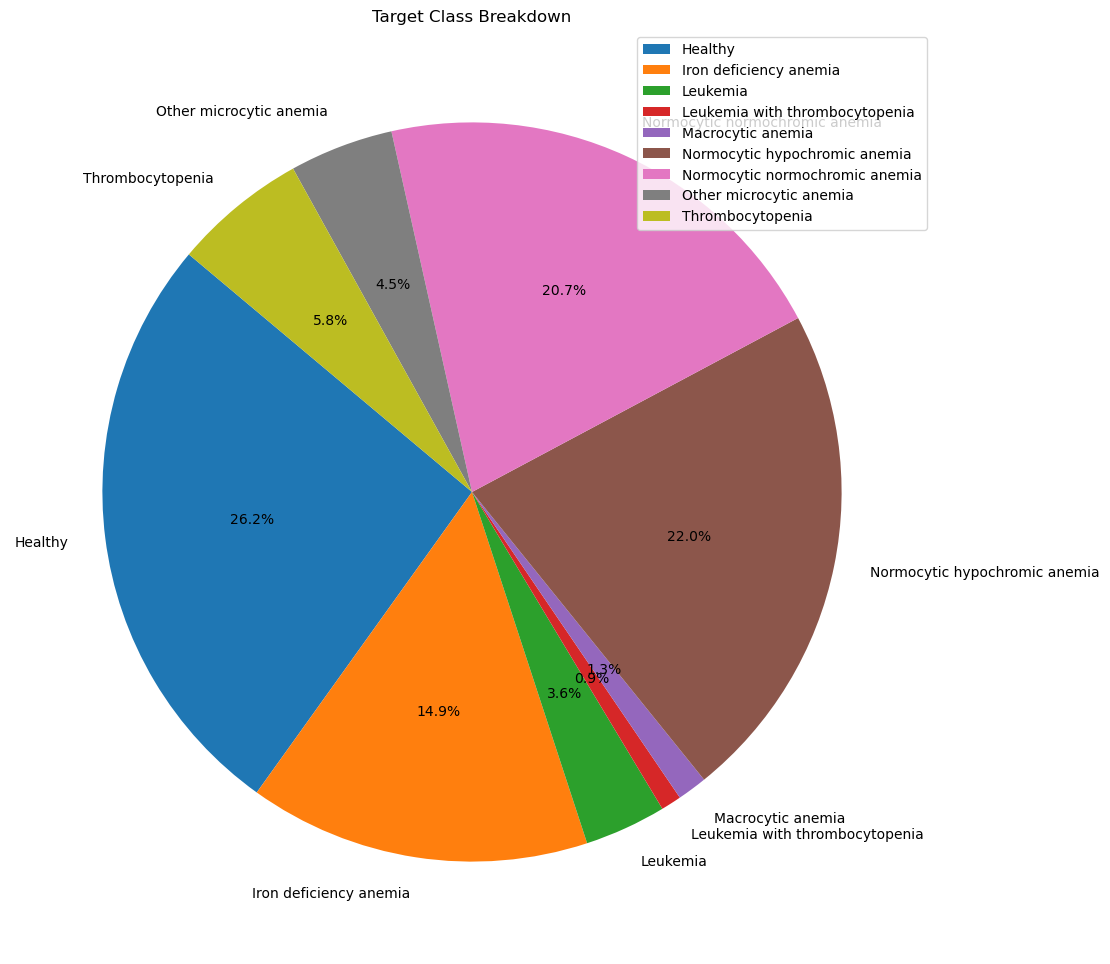

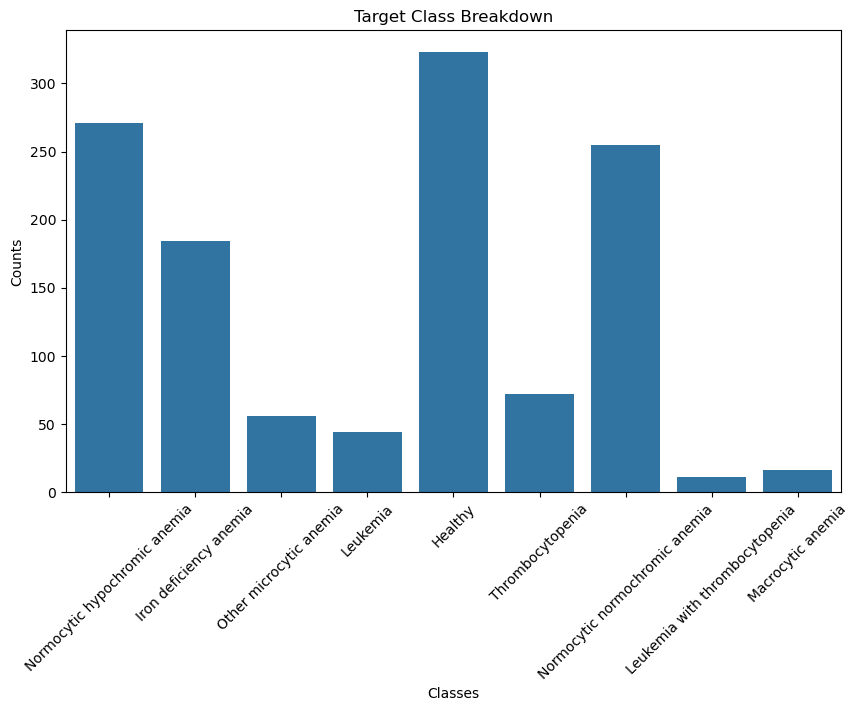

In [6]:
check_class_imbalances(df["Diagnosis"])

In [7]:
df.dtypes

WBC          float64
LYMp         float64
NEUTp        float64
LYMn         float64
NEUTn        float64
RBC          float64
HGB          float64
HCT          float64
MCV          float64
MCH          float64
MCHC         float64
PLT          float64
PDW          float64
PCT          float64
Diagnosis     object
dtype: object

In [8]:
df.describe()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,7.846713,25.897658,77.591978,1.884341,5.130724,4.714294,12.187589,46.269150,85.734099,32.250877,31.739732,228.927922,14.340931,0.261623
std,3.552180,7.064941,150.651596,1.357362,2.895636,2.867519,3.863201,106.945982,27.663902,113.356653,3.354512,93.080258,3.053868,0.698735
min,0.800000,6.200000,0.700000,0.200000,0.500000,1.360000,-10.000000,2.000000,-79.300000,10.900000,11.500000,10.000000,8.400000,0.010000
25%,6.000000,25.845000,70.775000,1.880760,5.000000,4.190000,10.800000,39.200000,81.000000,25.500000,30.500000,157.000000,13.300000,0.170000
50%,7.400000,25.845000,77.511000,1.880760,5.140940,4.600000,12.200000,46.152600,86.550000,27.700000,32.000000,211.000000,14.312512,0.260280
75%,8.700000,25.845000,77.511000,1.880760,5.140940,5.100000,13.500000,46.152600,90.200000,29.600000,32.900000,290.000000,14.800000,0.260280
max,45.700000,91.400000,5317.000000,41.800000,79.000000,90.800000,87.100000,3715.000000,990.000000,3117.000000,92.800000,660.000000,97.000000,13.600000


# Heat Map

<AxesSubplot:>

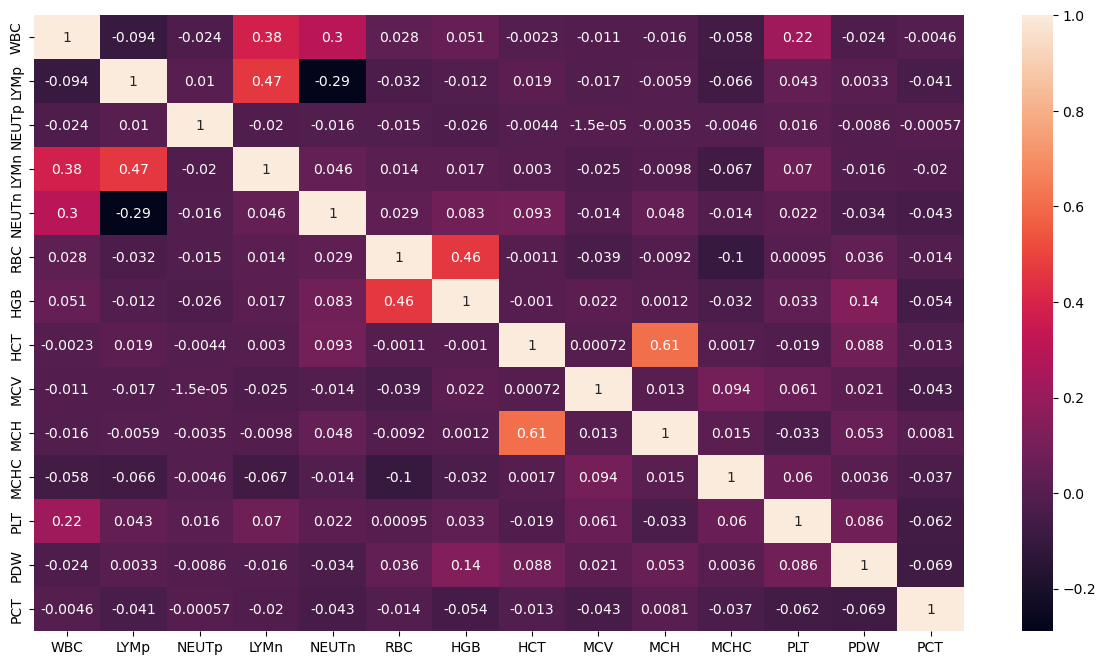

In [9]:
relations= df.drop("Diagnosis", axis=1).corr()
plt.figure(figsize=(15, 8))
sns.heatmap(data=relations, annot=True)

# We have so many dimensions that we're bound to get correlations given the amount of dimensions in the dataset. We might have to do PCA analysis to reduce the dimensions

# Separate Feature Variables

In [10]:
X,y = df.drop("Diagnosis", axis=1), df["Diagnosis"]

# Encode Target Variable

In [11]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Baseline Model

In [12]:
model = DummyClassifier(strategy="uniform")
pipeline = create_pipeline_object(model)
scores = evaluate_model(X, y_encoded, model)
print(f"Mean Accuracy-Score: {round(np.mean(scores),3)}, STD:{round(np.std(scores),3)}")

Mean Accuracy-Score: 0.107, STD:0.023


# Advanced Model Metrics

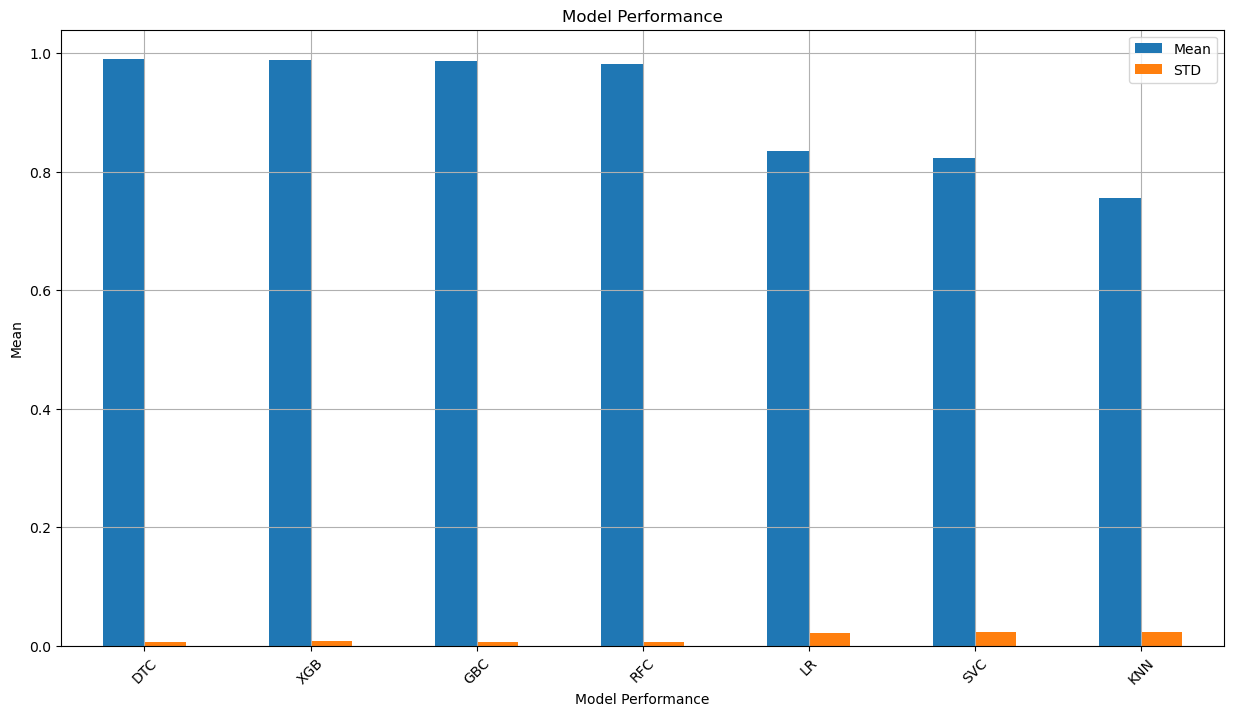

   index Model   Mean    STD
0      4   DTC  0.990  0.007
1      2   XGB  0.989  0.008
2      5   GBC  0.986  0.007
3      3   RFC  0.982  0.007
4      1    LR  0.834  0.021
5      0   SVC  0.823  0.023
6      6   KNN  0.756  0.023


In [13]:
model_names = ["SVC", "LR", "XGB", "RFC", "DTC", "GBC", "KNN"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X, y_encoded)

# Model is likely overfitting due to lack of examples for minority classes

# Lets look at the quality of predictions our off the shelf model creates. 

In [14]:
pipeline = create_pipeline_object()
X_preprocessed = pipeline.fit_transform(X)

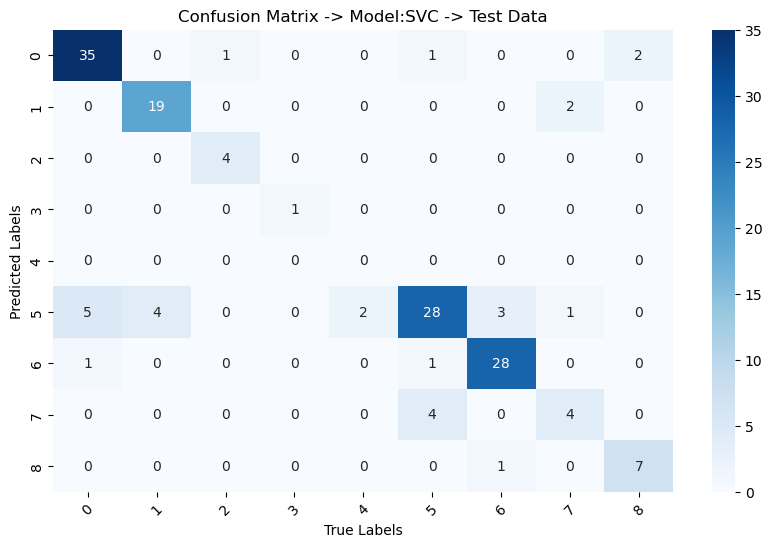

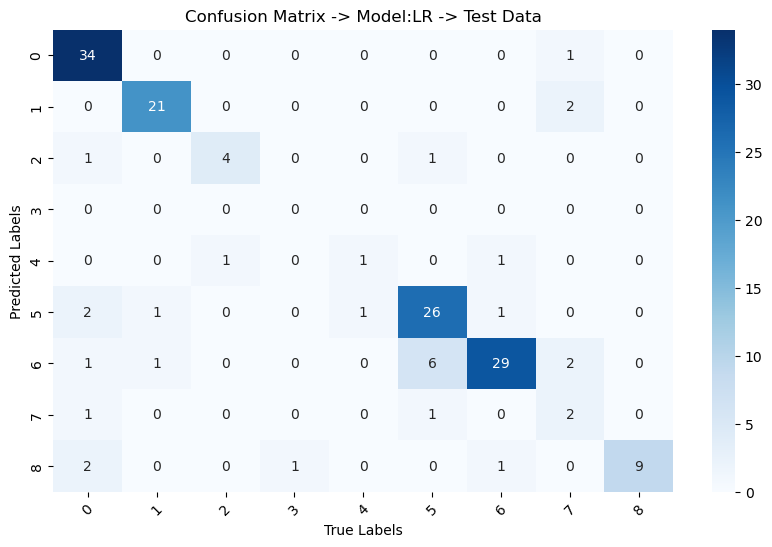

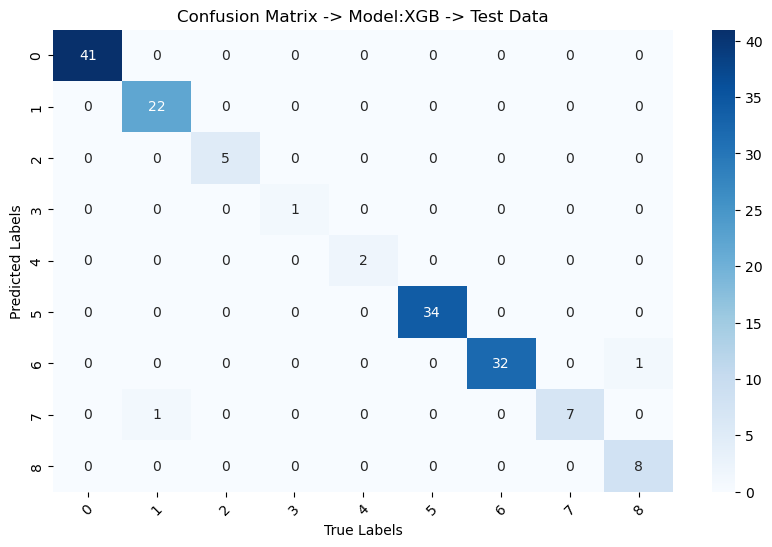

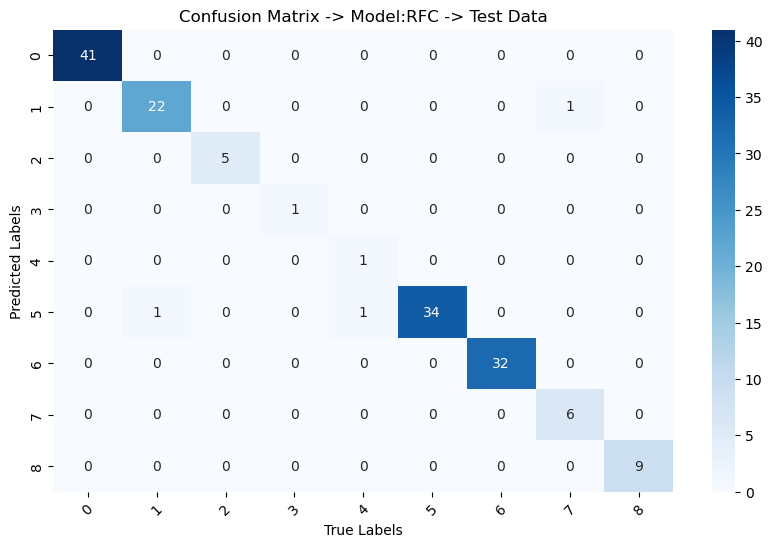

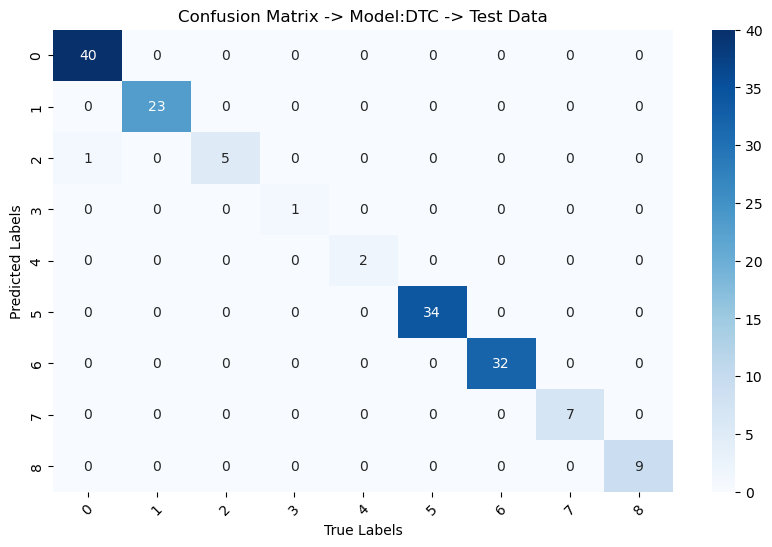

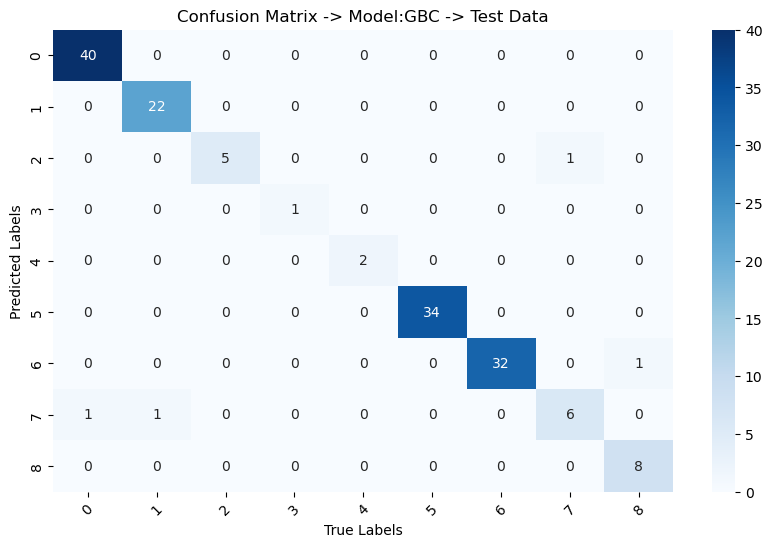

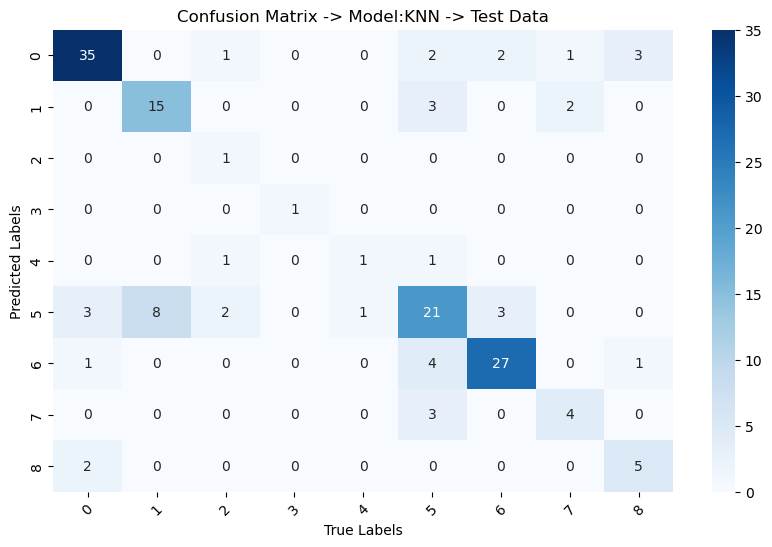

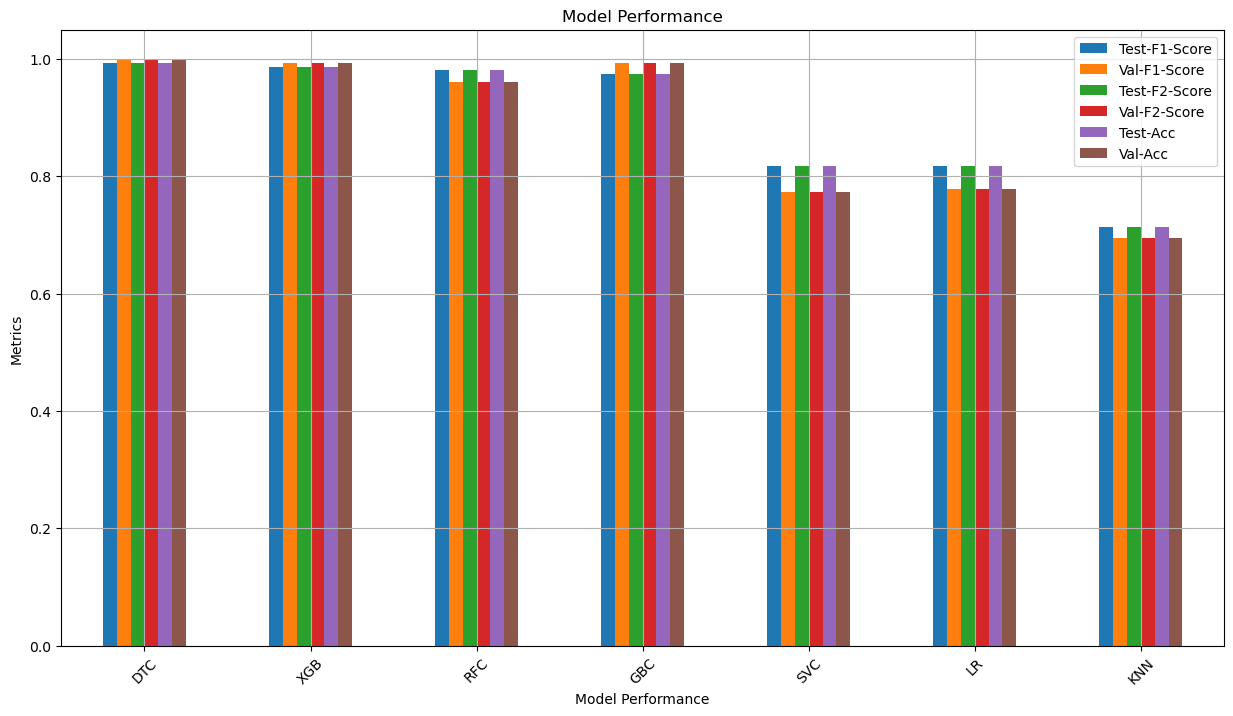

   index Model  Test-F1-Score  Val-F1-Score  Test-F2-Score  Val-F2-Score  \
0      4   DTC       0.993506      1.000000       0.993506      1.000000   
1      2   XGB       0.987013      0.993506       0.987013      0.993506   
2      3   RFC       0.980519      0.961039       0.980519      0.961039   
3      5   GBC       0.974026      0.993506       0.974026      0.993506   
4      0   SVC       0.818182      0.772727       0.818182      0.772727   
5      1    LR       0.818182      0.779221       0.818182      0.779221   
6      6   KNN       0.714286      0.694805       0.714286      0.694805   

   Test-Acc   Val-Acc  
0  0.993506  1.000000  
1  0.987013  0.993506  
2  0.980519  0.961039  
3  0.974026  0.993506  
4  0.818182  0.772727  
5  0.818182  0.779221  
6  0.714286  0.694805  


In [15]:
test_predictions(model_names, models, X_preprocessed, y_encoded)

# Our models are clearly overfitting to the data set which means we will have to implement sampling methods to get the best results.

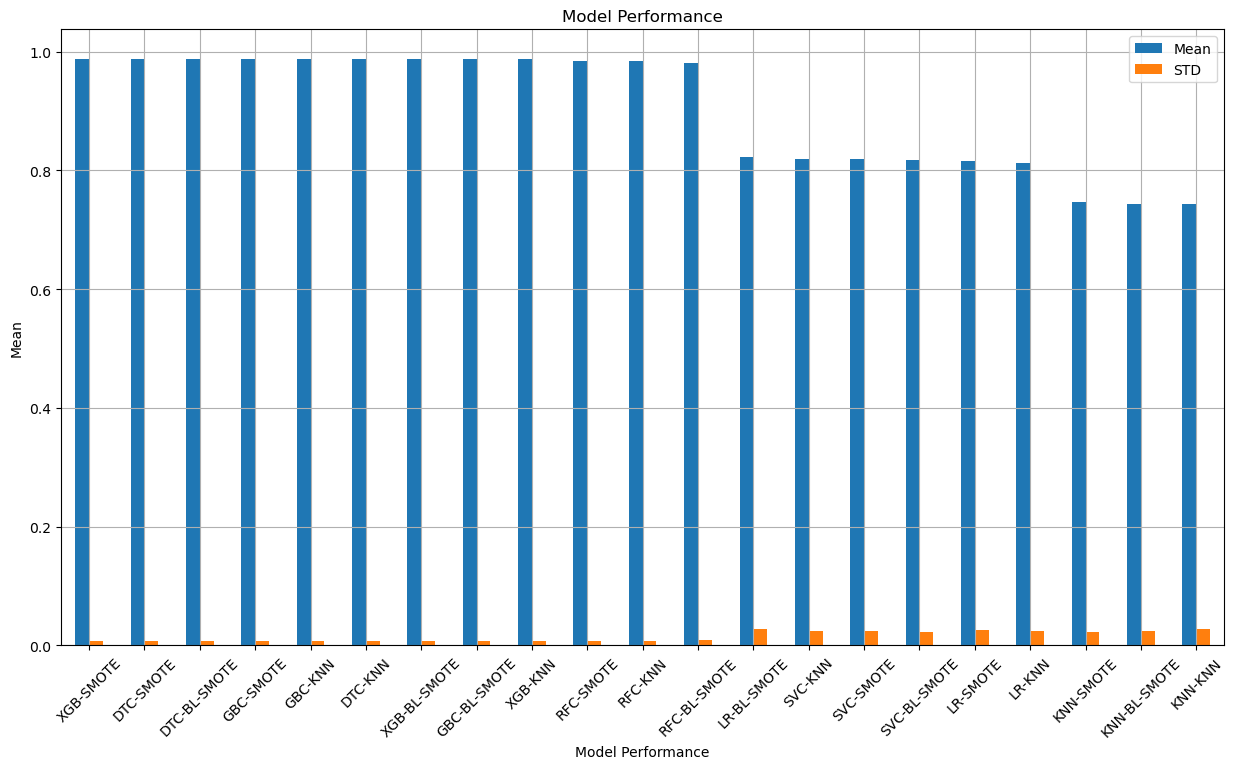

    index         Model   Mean    STD
0       2     XGB-SMOTE  0.988  0.008
1       4     DTC-SMOTE  0.988  0.007
2      11  DTC-BL-SMOTE  0.988  0.007
3       5     GBC-SMOTE  0.987  0.007
4      19       GBC-KNN  0.987  0.007
5      18       DTC-KNN  0.987  0.007
6       9  XGB-BL-SMOTE  0.987  0.007
7      12  GBC-BL-SMOTE  0.987  0.008
8      16       XGB-KNN  0.987  0.008
9       3     RFC-SMOTE  0.985  0.008
10     17       RFC-KNN  0.984  0.008
11     10  RFC-BL-SMOTE  0.981  0.009
12      8   LR-BL-SMOTE  0.822  0.028
13     14       SVC-KNN  0.819  0.024
14      0     SVC-SMOTE  0.819  0.025
15      7  SVC-BL-SMOTE  0.817  0.022
16      1      LR-SMOTE  0.815  0.026
17     15        LR-KNN  0.813  0.024
18      6     KNN-SMOTE  0.747  0.023
19     13  KNN-BL-SMOTE  0.744  0.025
20     20       KNN-KNN  0.744  0.027


In [16]:
sampling_model_names = ["SMOTE","BL-SMOTE","KNN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_preprocessed, y_encoded)

# DTC seems to perform the best but lets test out all of our models on predictions

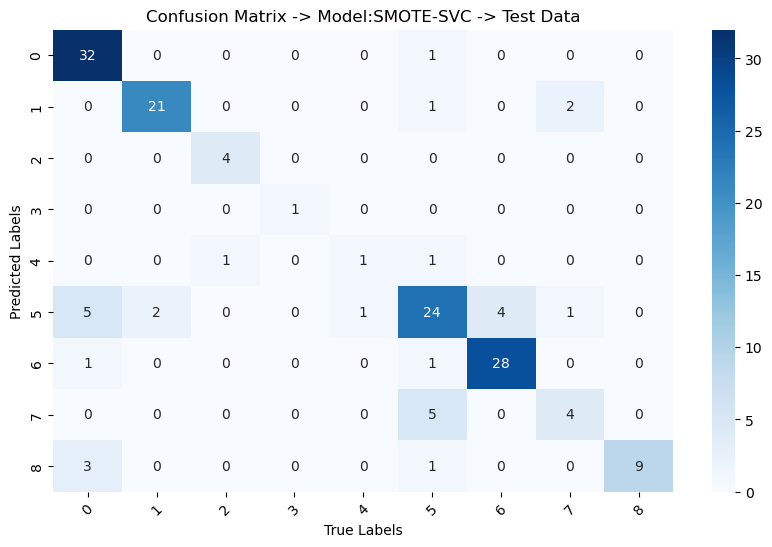

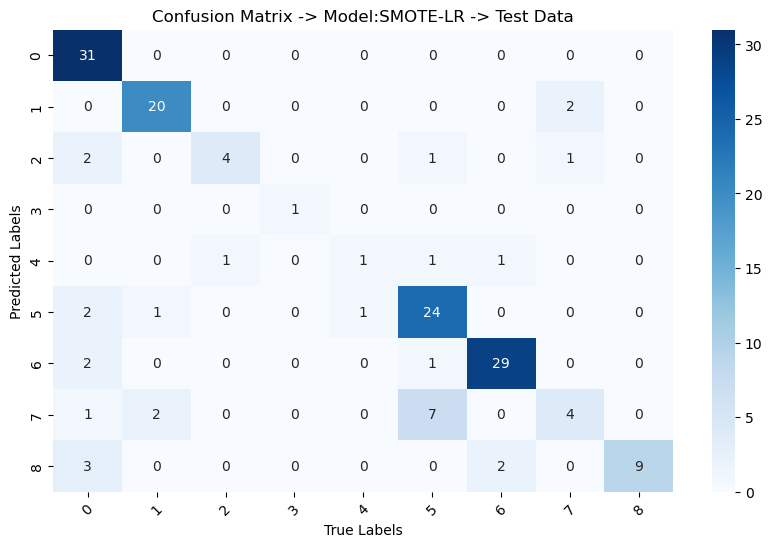

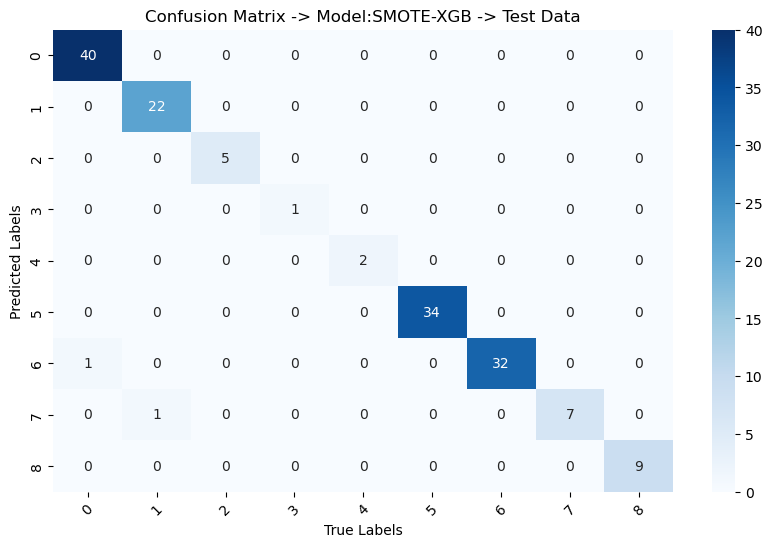

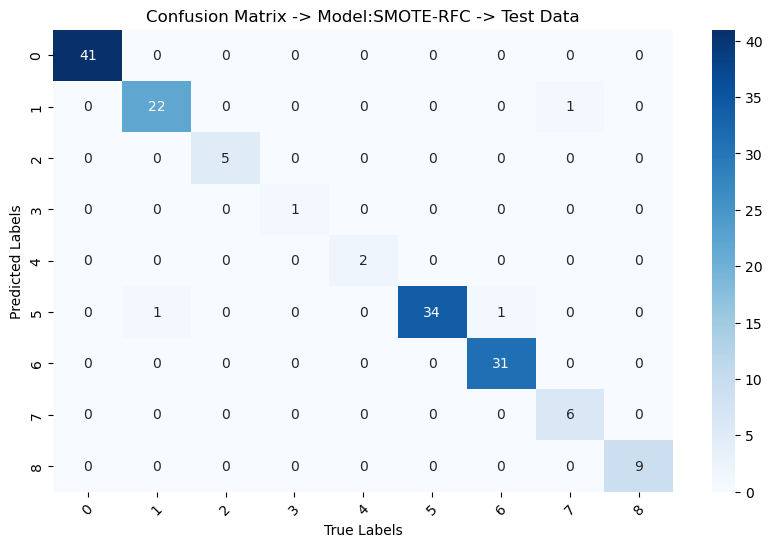

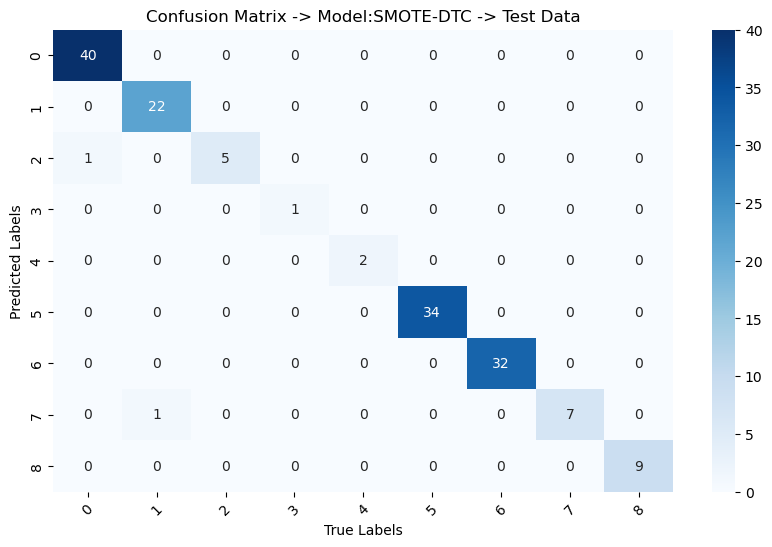

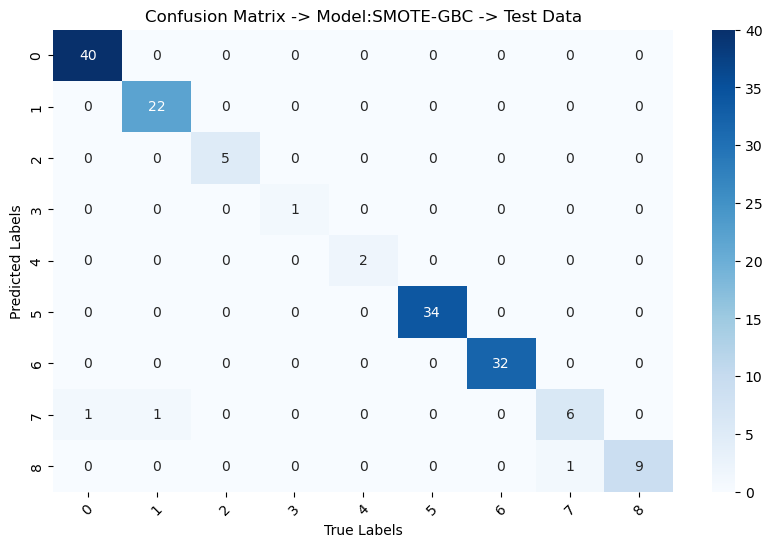

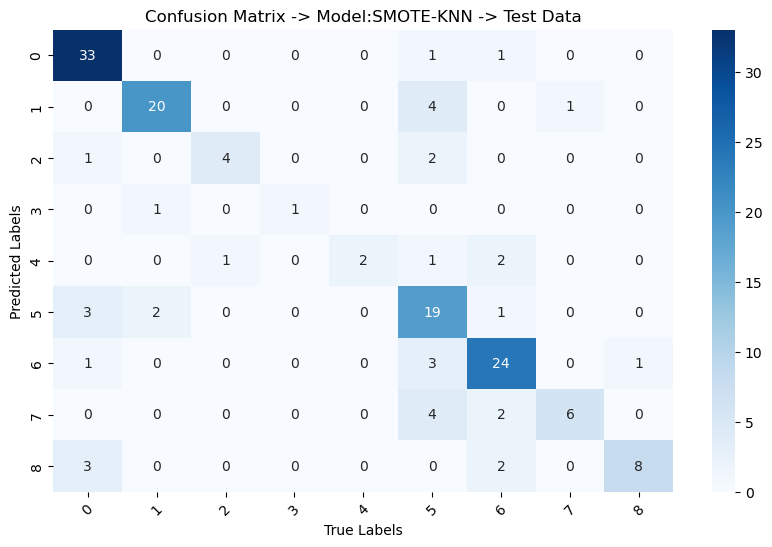

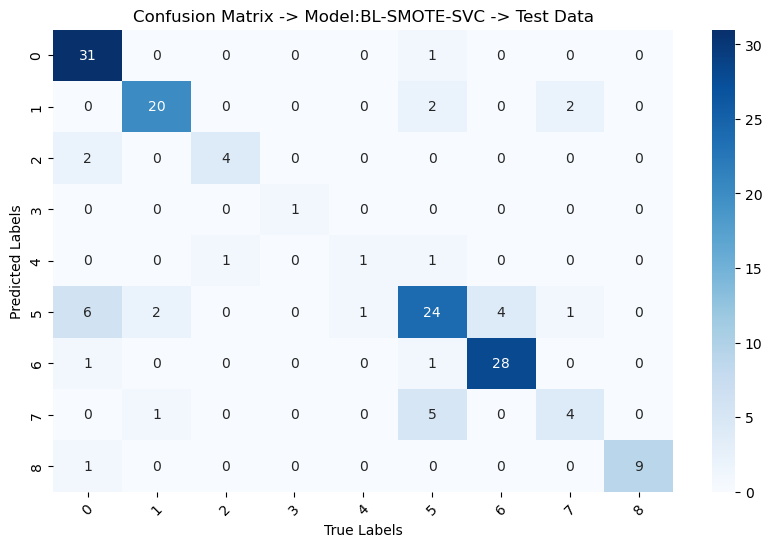

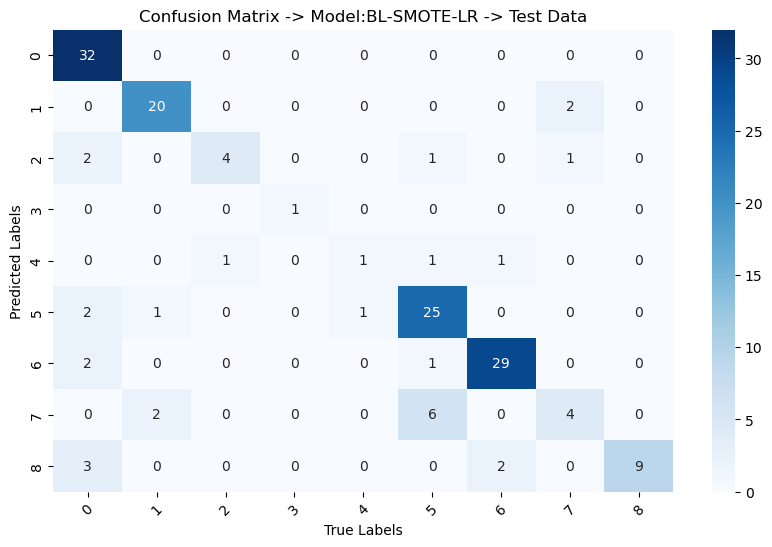

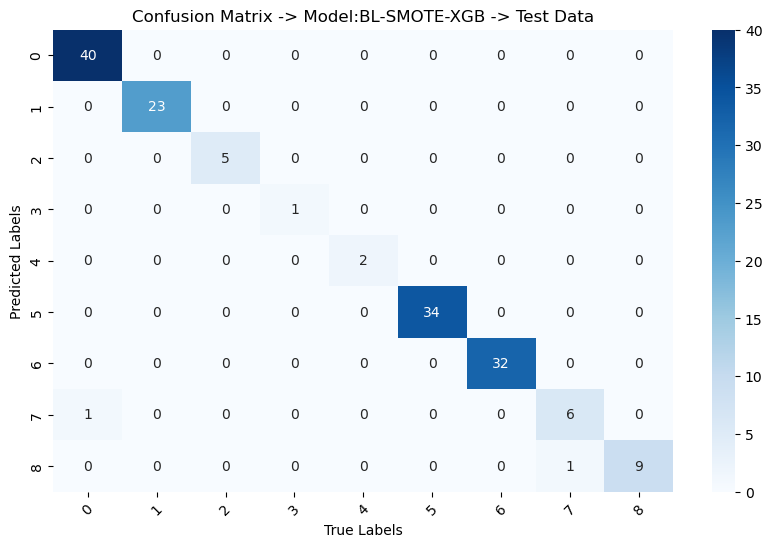

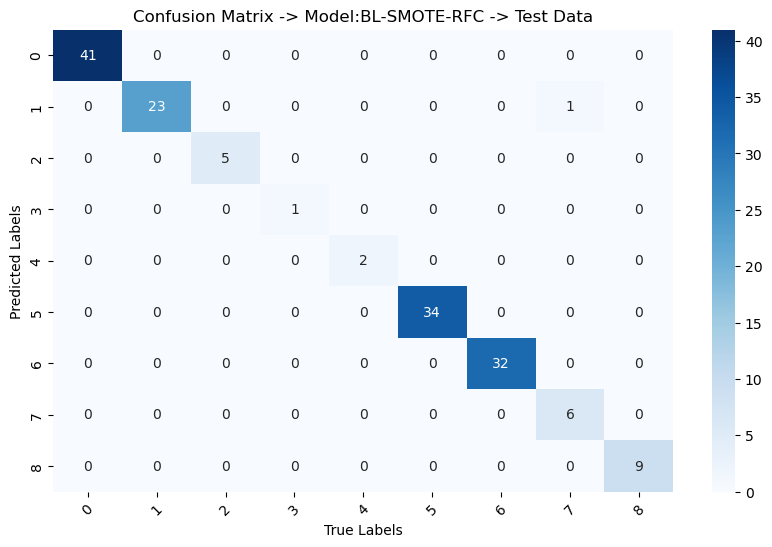

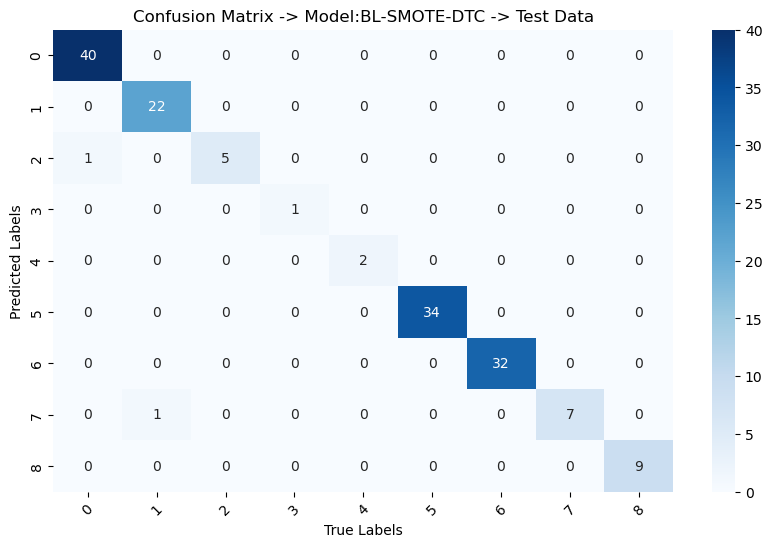

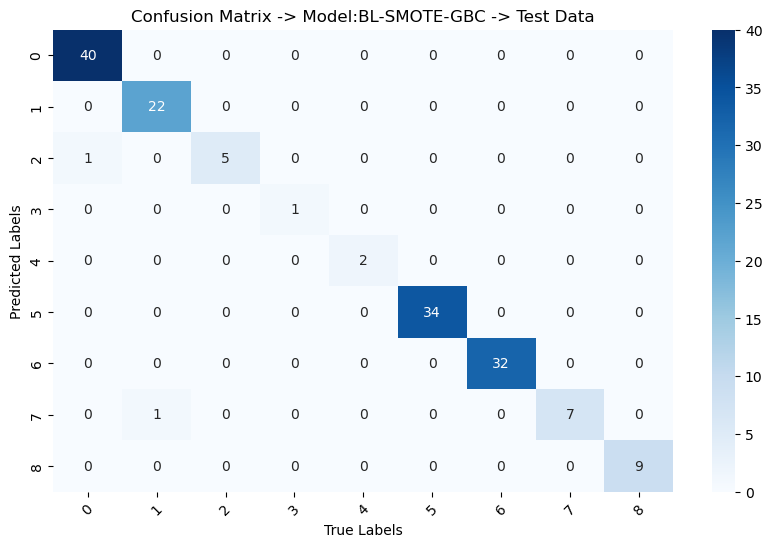

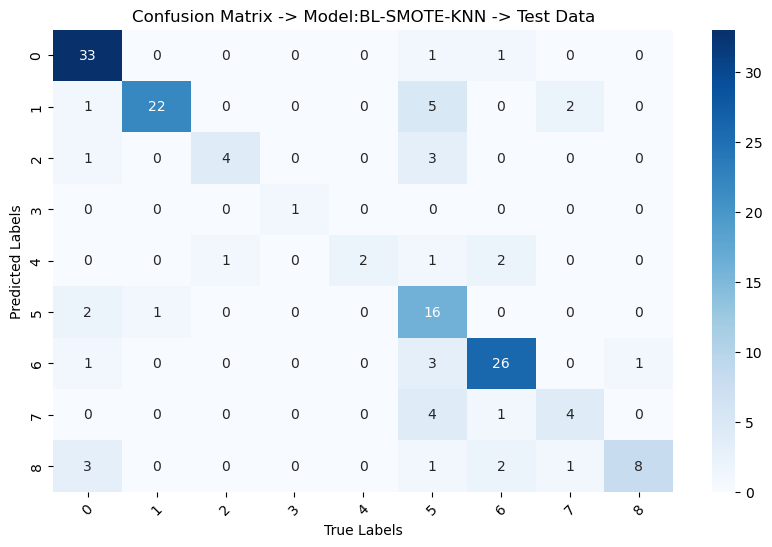

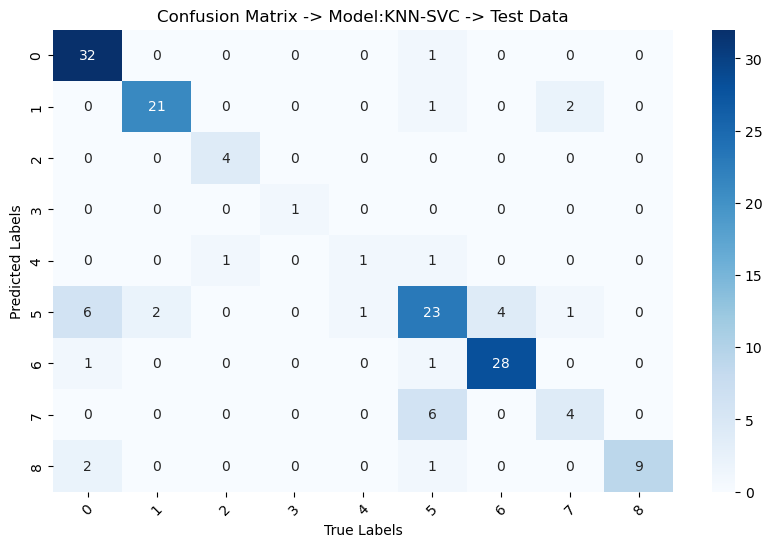

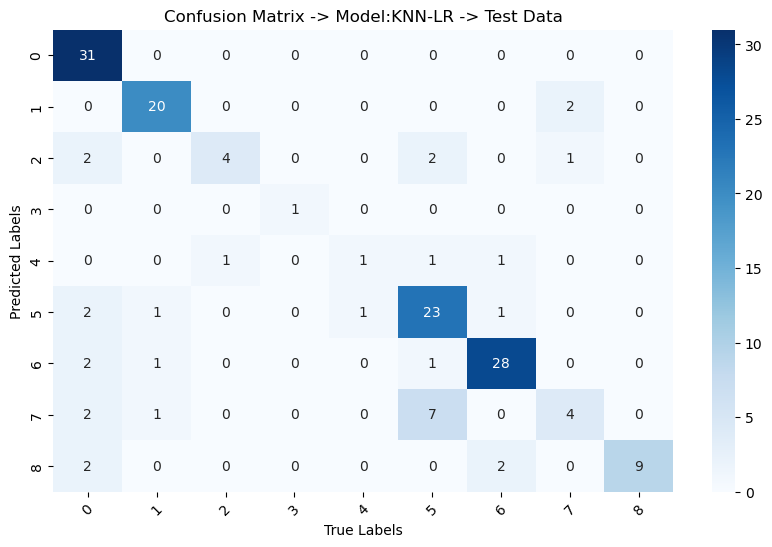

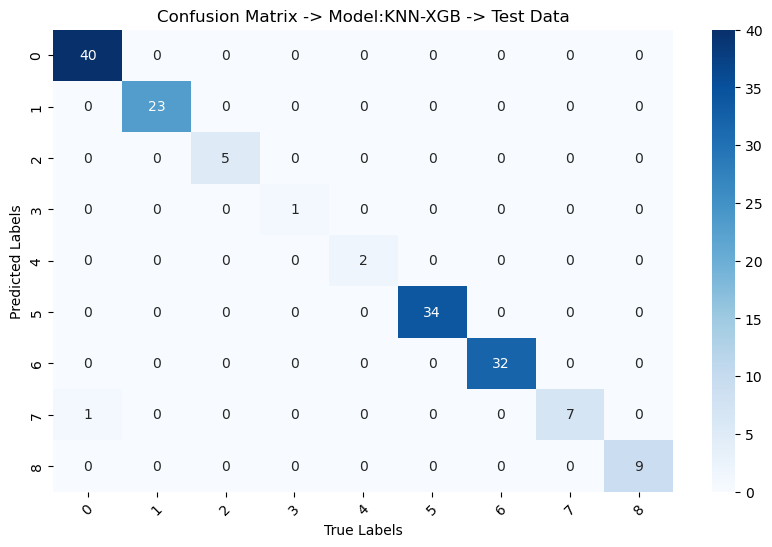

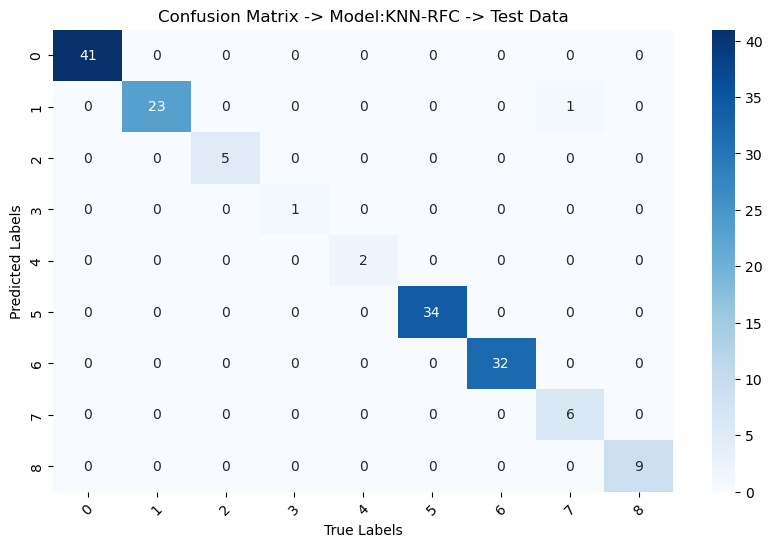

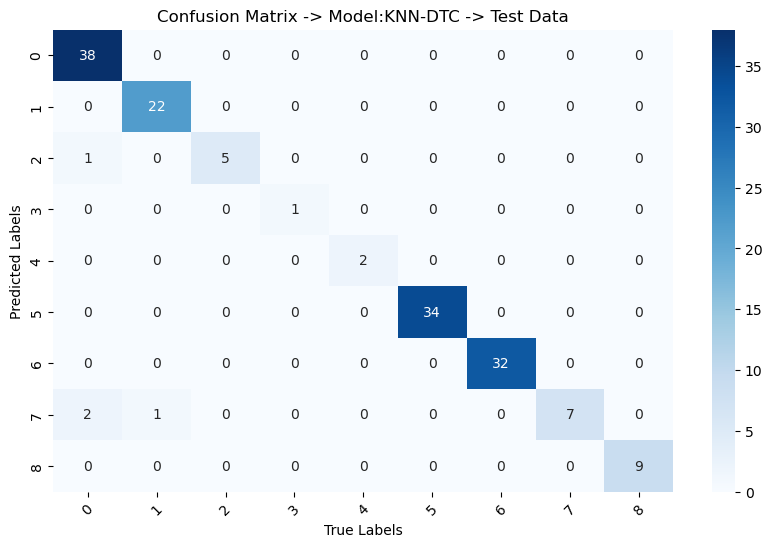

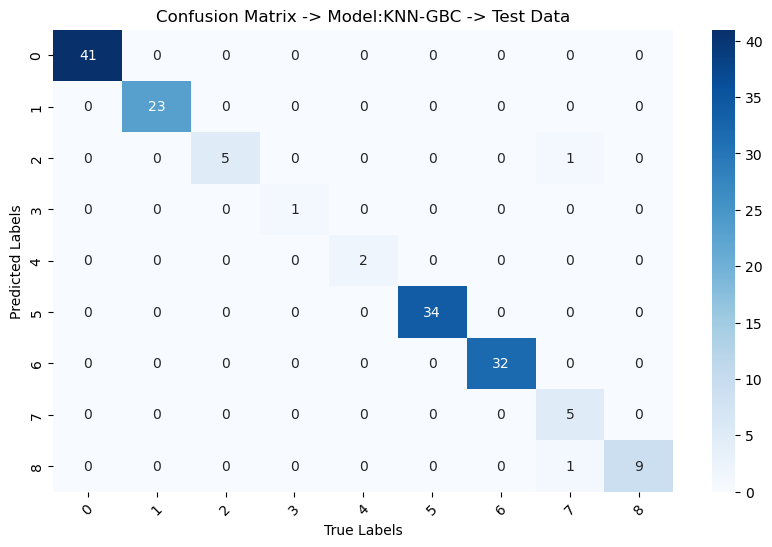

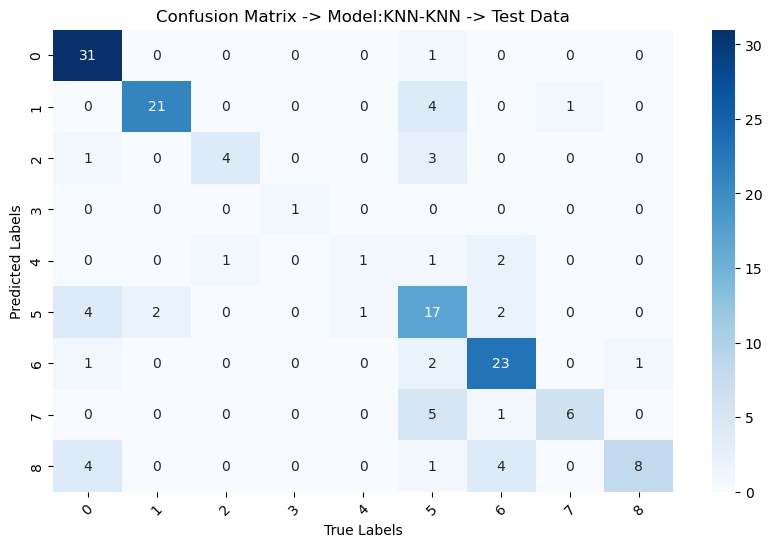

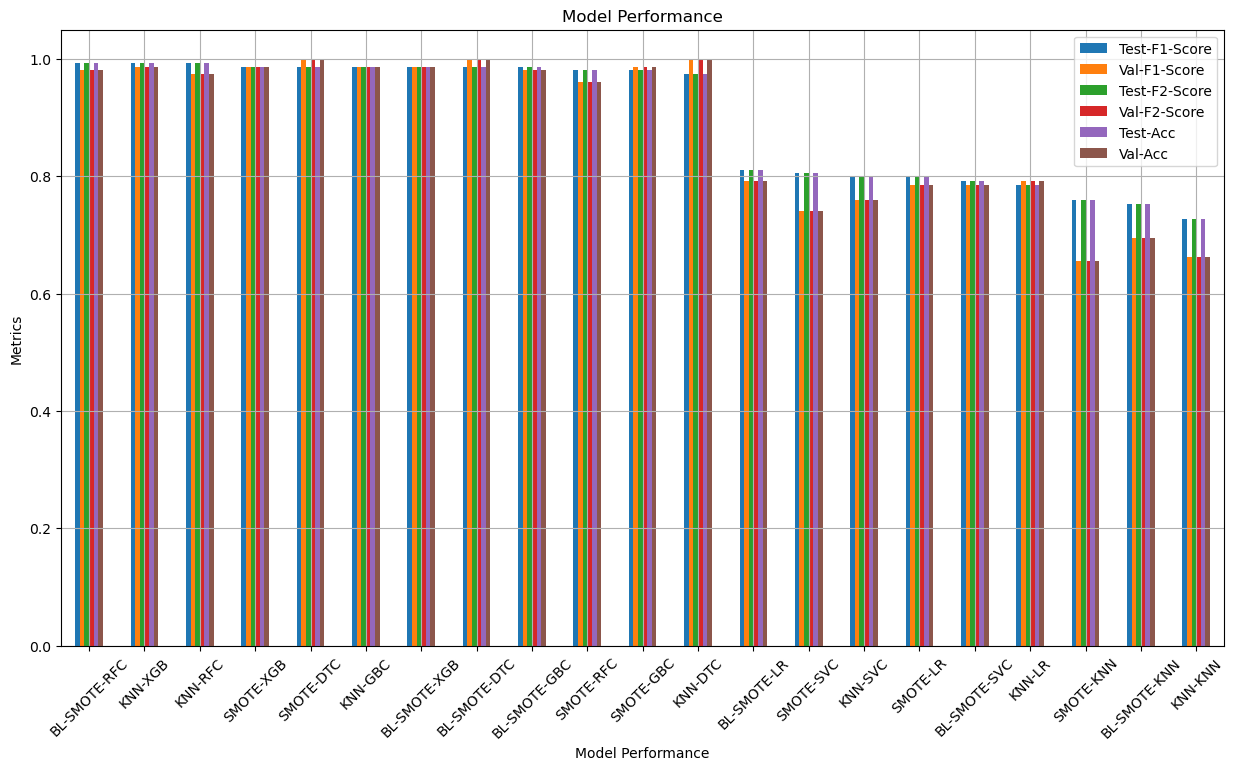

    index         Model  Test-F1-Score  Val-F1-Score  Test-F2-Score  \
0      10  BL-SMOTE-RFC       0.993506      0.980519       0.993506   
1      16       KNN-XGB       0.993506      0.987013       0.993506   
2      17       KNN-RFC       0.993506      0.974026       0.993506   
3       2     SMOTE-XGB       0.987013      0.987013       0.987013   
4       4     SMOTE-DTC       0.987013      1.000000       0.987013   
5      19       KNN-GBC       0.987013      0.987013       0.987013   
6       9  BL-SMOTE-XGB       0.987013      0.987013       0.987013   
7      11  BL-SMOTE-DTC       0.987013      1.000000       0.987013   
8      12  BL-SMOTE-GBC       0.987013      0.980519       0.987013   
9       3     SMOTE-RFC       0.980519      0.961039       0.980519   
10      5     SMOTE-GBC       0.980519      0.987013       0.980519   
11     18       KNN-DTC       0.974026      1.000000       0.974026   
12      8   BL-SMOTE-LR       0.811688      0.792208       0.811688   
13    

In [17]:
test_sampling_model_predictions(sampling_model_names, sampling_models, model_names, models, X_preprocessed, y_encoded)

# Interesting to note here that the top 10 models have a test f1 score of 98% or higher, with some model combinations like KNN GBC clearly overfitting. It's hard to choose which combination will give the best results given that we have so many different combinations between sampling and model choices while performance remains high.

# Lets conduct a PCA Analysis and determine if we can remove some columns without impacting performance

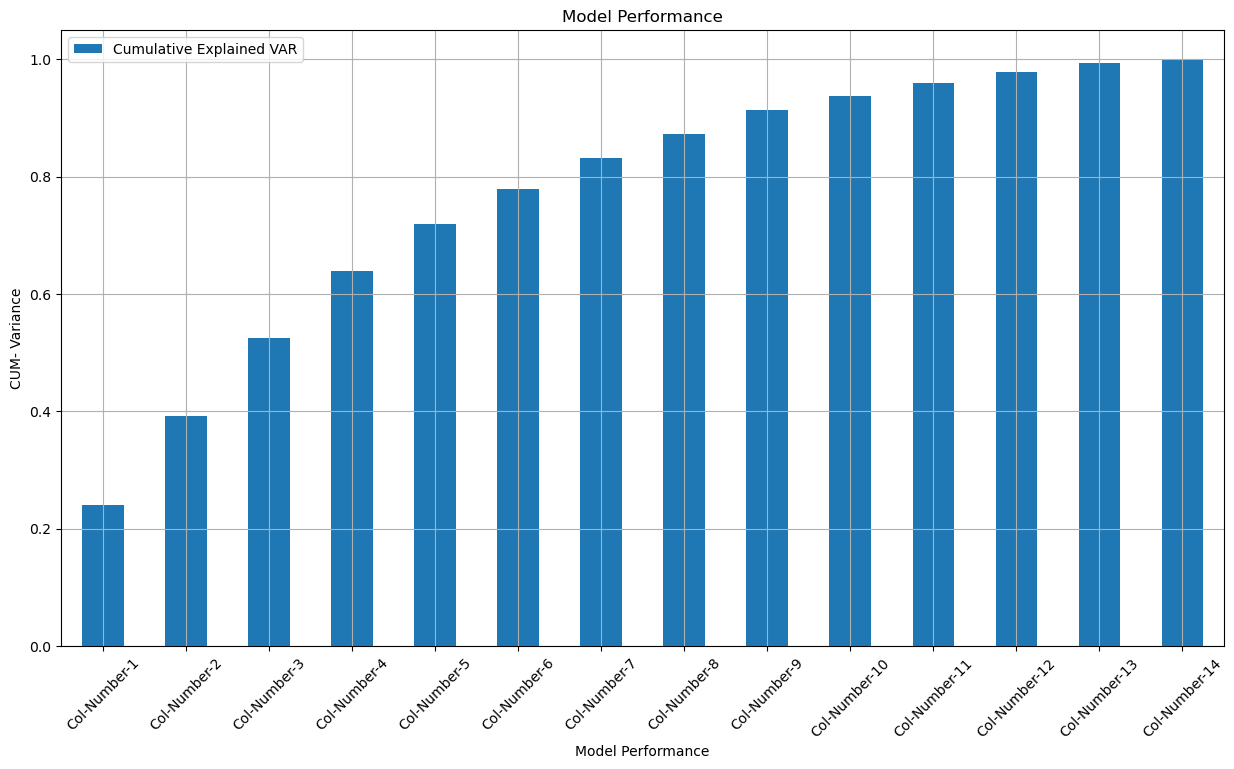

            Model  N Component  Cumulative Explained VAR
0    Col-Number-1            1                  0.240991
1    Col-Number-2            2                  0.391202
2    Col-Number-3            3                  0.524422
3    Col-Number-4            4                  0.639246
4    Col-Number-5            5                  0.718531
5    Col-Number-6            6                  0.778541
6    Col-Number-7            7                  0.830912
7    Col-Number-8            8                  0.873325
8    Col-Number-9            9                  0.913967
9   Col-Number-10           10                  0.938186
10  Col-Number-11           11                  0.958715
11  Col-Number-12           12                  0.978528
12  Col-Number-13           13                  0.992894
13  Col-Number-14           14                  1.000000


In [18]:
pca_analysis(X_preprocessed)

# 71% - 95% of the variance is from 5- 11 columns. This tells us we might be able to remove some of the features in our dataset to reduce dimesionality and the complexity of our models.

# Test for K best columns using Fstat

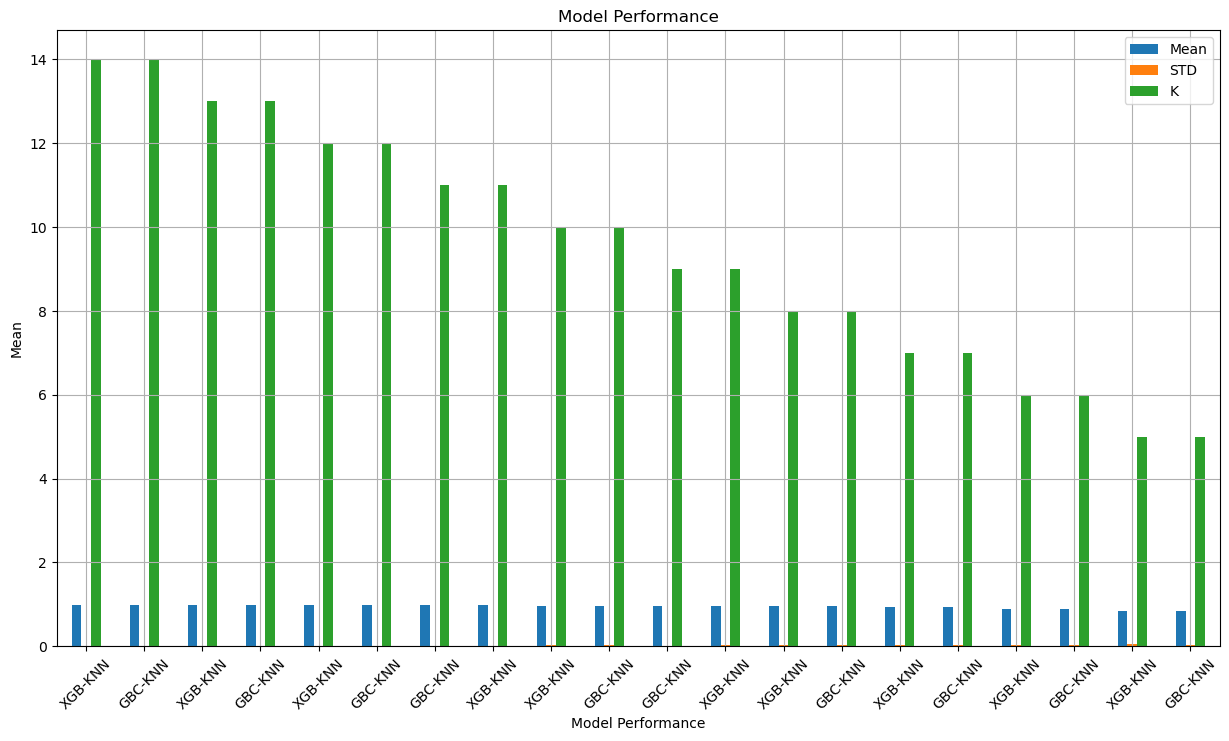

    index    Model   Mean    STD   K
0      19  XGB-KNN  0.988  0.008  14
1      18  GBC-KNN  0.988  0.007  14
2      17  XGB-KNN  0.987  0.008  13
3      16  GBC-KNN  0.987  0.008  13
4      15  XGB-KNN  0.987  0.008  12
5      14  GBC-KNN  0.987  0.007  12
6      12  GBC-KNN  0.987  0.007  11
7      13  XGB-KNN  0.986  0.013  11
8      11  XGB-KNN  0.958  0.016  10
9      10  GBC-KNN  0.958  0.015  10
10      8  GBC-KNN  0.955  0.014   9
11      9  XGB-KNN  0.954  0.020   9
12      7  XGB-KNN  0.949  0.022   8
13      6  GBC-KNN  0.947  0.023   8
14      5  XGB-KNN  0.943  0.035   7
15      4  GBC-KNN  0.936  0.037   7
16      3  XGB-KNN  0.896  0.028   6
17      2  GBC-KNN  0.880  0.033   6
18      1  XGB-KNN  0.838  0.041   5
19      0  GBC-KNN  0.832  0.038   5


In [19]:
model_names = ["GBC", "XGB"]
models = grab_selected_models(model_names)

sampling_model_names = ["KNN", "KNN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

variance_window = range(5, 14+1)
kmetric = f_classif

test_kBest_columns(model_names, sampling_model_names, models, sampling_models, X_preprocessed, y_encoded, variance_window, kmetric)

# We can acheive the same model performance with around 10-12 columns. Lets test mutual information and see if there is a discernable difference between the two

In [20]:
model_names = ["GBC", "XGB"]
models = grab_selected_models(model_names)

sampling_model_names = ["KNN", "KNN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

variance_window = range(5, 14+1)
kmetric = mutual_info_classif

test_kBest_columns(model_names, sampling_model_names, models, sampling_models, X_preprocessed, y_encoded, variance_window, kmetric)

# Mutual Information performs far better than fstat. With this method, we're able to reduce our feature columns from 7-10 which is almost 50% down from our original set which was 14.

# Lets test this on some predictions and see if it holds up

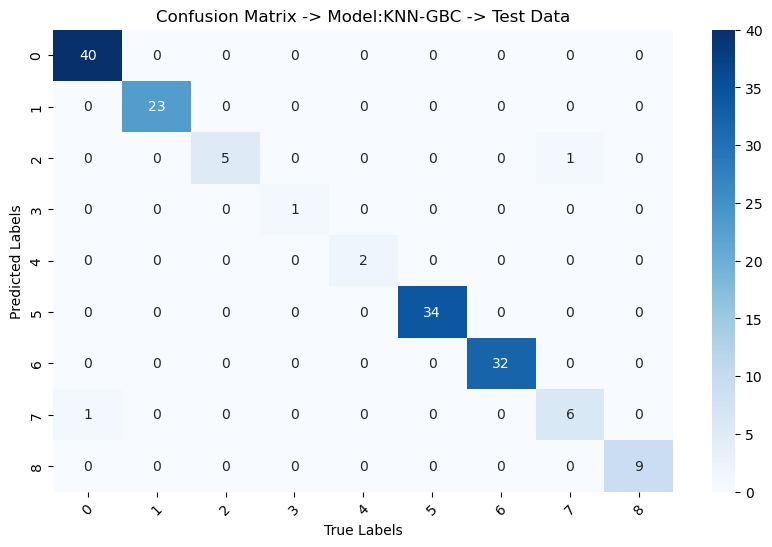

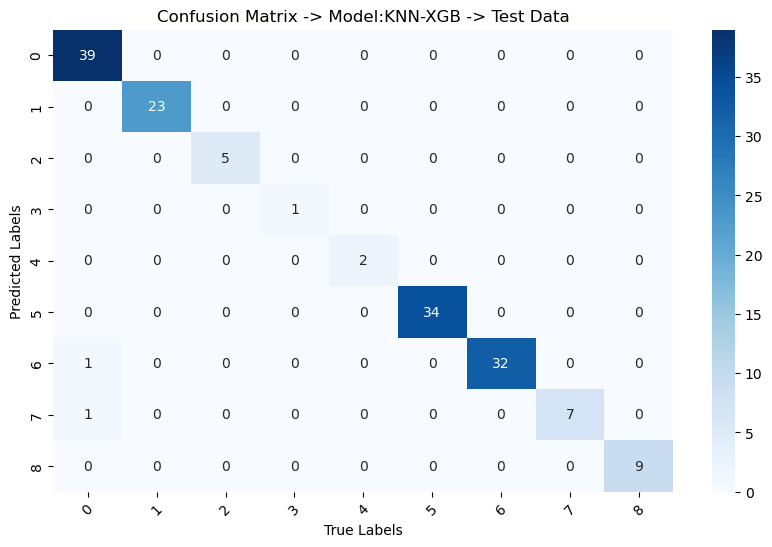

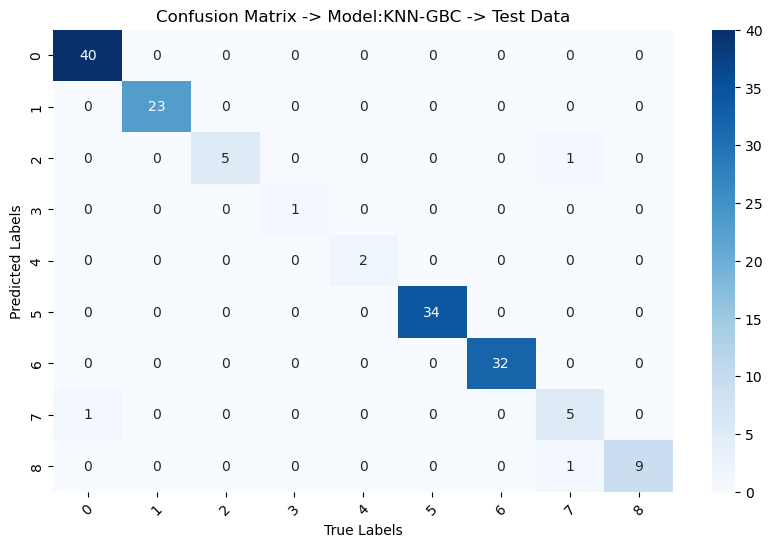

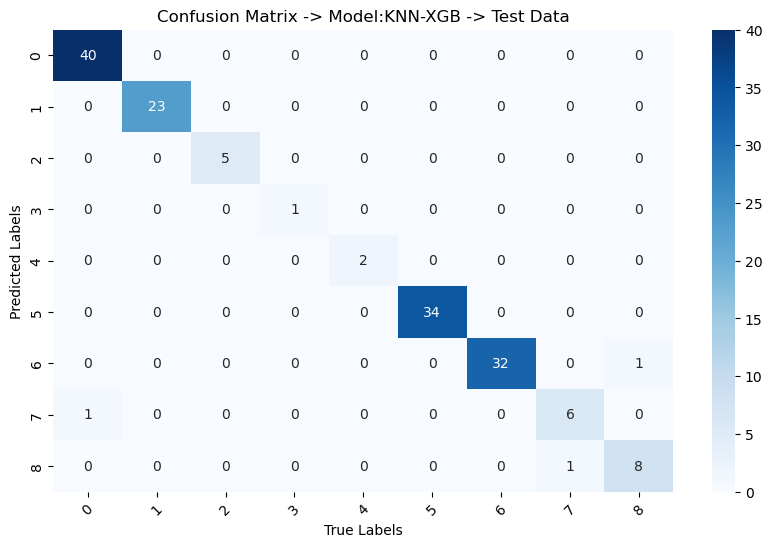

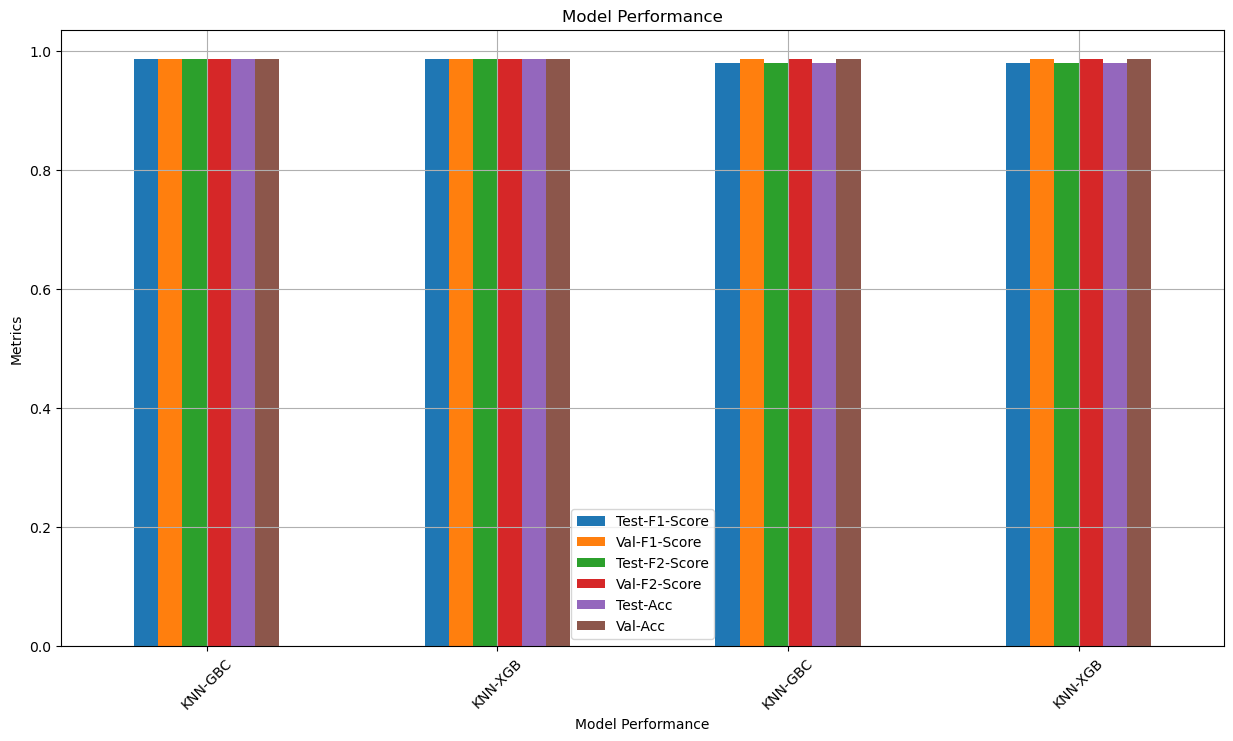

   index    Model  Test-F1-Score  Val-F1-Score  Test-F2-Score  Val-F2-Score  \
0      0  KNN-GBC       0.987013      0.987013       0.987013      0.987013   
1      1  KNN-XGB       0.987013      0.987013       0.987013      0.987013   
2      2  KNN-GBC       0.980519      0.987013       0.980519      0.987013   
3      3  KNN-XGB       0.980519      0.987013       0.980519      0.987013   

   Test-Acc   Val-Acc  
0  0.987013  0.987013  
1  0.987013  0.987013  
2  0.980519  0.987013  
3  0.980519  0.987013  


In [ ]:
metric = SelectKBest(score_func=mutual_info_classif, k=10)
test_sampling_model_predictions(sampling_model_names, sampling_models, model_names, models, X_preprocessed, y_encoded, metric)

# Conclusion: We were able to test an array of models along with over sampling techniques, PCA analysis and find the Kbest columns in our dataset to reduce the dimensionality of our data, reducing noise and computation time. Next time, we should focus on tuning our model to avoid overfitting our dataset with parameters for our tree models.